# QBS108 -  HW 4

Deepanshi Shokeen

In [61]:
# Importing Libraries

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import precision_score,accuracy_score,f1_score,recall_score
plt.ion()   # interactive mode

import numpy as np 
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import matplotlib.pyplot as plt

## 1.1. Data Loading and Tranformation

**1.  Create data transformations for image augmentation and normalization in training and validation set.**

In [62]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

**2.  Using datasets.ImageFolderundertorchvision, load the training and validation datasets fromimgfolder, and apply the transformations you created in 1.1 on each dataset.**

In [63]:
data_dir = '/Users/deepanshishokeen/desktop/spring/QBS108/img'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Create dataloaders for training and validation dataset usingtorch.utils.data.DataLoader.**

In [64]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

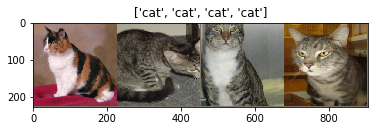

In [65]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 1.2.    Define loss function and optimizer

In [66]:
import torch.optim as optim
# Using cross entropy loss
criterion = nn.CrossEntropyLoss()

# Using Adam optimizer
optimizer = optim.Adam(lr=0.001)

## 1.3. Train Resnet18 from scratch

**1. Initialize a Resnet18 model (not pre-trained) and change the size of outputlayer to 2**

In [73]:
val_loss_history= []
train_loss_history= []
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                correct = 0
                total = 0
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [74]:
model_ft = models.resnet18(pretrained=False)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, betas=(0.9, 0.999),weight_decay=1e-4)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [75]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=40)

Epoch 0/39
----------
train Loss: 0.8572 Acc: 0.5180
val Loss: 0.8655 Acc: 0.4300

Epoch 1/39
----------
train Loss: 0.7109 Acc: 0.5440
val Loss: 0.8533 Acc: 0.5400

Epoch 2/39
----------
train Loss: 0.7237 Acc: 0.5360
val Loss: 0.7275 Acc: 0.5700

Epoch 3/39
----------
train Loss: 0.6924 Acc: 0.5620
val Loss: 0.7346 Acc: 0.4800

Epoch 4/39
----------
train Loss: 0.6910 Acc: 0.5400
val Loss: 1.0199 Acc: 0.5300

Epoch 5/39
----------
train Loss: 0.7038 Acc: 0.5360
val Loss: 0.7198 Acc: 0.4900

Epoch 6/39
----------
train Loss: 0.6972 Acc: 0.5700
val Loss: 0.6792 Acc: 0.5900

Epoch 7/39
----------
train Loss: 0.6965 Acc: 0.5600
val Loss: 0.7937 Acc: 0.4300

Epoch 8/39
----------
train Loss: 0.7119 Acc: 0.4760
val Loss: 0.6582 Acc: 0.5900

Epoch 9/39
----------
train Loss: 0.6768 Acc: 0.5880
val Loss: 0.6578 Acc: 0.5700

Epoch 10/39
----------
train Loss: 0.6648 Acc: 0.6000
val Loss: 0.6712 Acc: 0.6100

Epoch 11/39
----------
train Loss: 0.6591 Acc: 0.6360
val Loss: 0.6573 Acc: 0.6200

Ep

**2. Train the model for a maximum of 50 epochs.  Record the training loss at  each  epoch.    Test  the  model  performance  on  the  validation set at each epoch and record the validation loss.  You can tune several hyper-parameters including batch size, learning rate, weight decay, etc.  to im-prove the model’s performance.  Report the training and validation loss every 10 epochs and plot the overall training and validation loss curves.**

In [77]:
train_loss_history

[0.857153475522995,
 0.7108612620830536,
 0.7237320132255555,
 0.6924416599273682,
 0.6909540219306946,
 0.7037882931232452,
 0.6971654269695282,
 0.6964672498703003,
 0.7119445550441742,
 0.676815087556839,
 0.6647505903244019,
 0.6591181380748748,
 0.6544705467224121,
 0.6489051492214203,
 0.6491395950317382,
 0.6385922937393188,
 0.6226102287769317,
 0.6660681457519532,
 0.6654409945011139,
 0.6374835257530213,
 0.6439518318176269,
 0.6334030108451844,
 0.6525046224594117,
 0.6396626415252685,
 0.6379898238182068,
 0.6348528304100036,
 0.6334387996196746,
 0.6167866744995117,
 0.6258258714675903,
 0.6374986772537231,
 0.6494857547283173,
 0.6325540292263031,
 0.616774361371994,
 0.6434805648326873,
 0.6460717873573303,
 0.6405027704238891,
 0.6361476213932037,
 0.6205768468379974,
 0.6436974549293518,
 0.6411913402080536]

In [78]:
val_loss_history

[0.8654578101634979,
 0.8533304131031036,
 0.727459899187088,
 0.7345519542694092,
 1.0198795759677888,
 0.7198358488082885,
 0.6791764450073242,
 0.7937249195575714,
 0.6582093572616577,
 0.6578147399425507,
 0.6711884355545044,
 0.657314133644104,
 0.658162910938263,
 0.668045597076416,
 0.6689791774749756,
 0.6756939923763275,
 0.6732054078578948,
 0.679306515455246,
 0.6691104114055634,
 0.6695004296302796,
 0.6729403531551361,
 0.6877875673770905,
 0.6880589962005615,
 0.6873229789733887,
 0.6803139424324036,
 0.6860020971298217,
 0.6745138812065125,
 0.6806120824813843,
 0.6786427509784698,
 0.681148921251297,
 0.6815475797653199,
 0.6909844017028809,
 0.6985801732540131,
 0.6781686270236968,
 0.6827126801013946,
 0.6762283933162689,
 0.6897651505470276,
 0.6890841960906983,
 0.6832832133769989,
 0.6985577630996704]

### Reporting training loss every 10 epochs

In [79]:
for x in range(len(train_loss_history)): 
    if x%10 ==0 :
        print(train_loss_history[x])

0.857153475522995
0.6647505903244019
0.6439518318176269
0.6494857547283173


### Reporting validation loss every 10 epochs

In [80]:
for x in range(len(val_loss_history)): 
    if x%10 ==0 :
        print(val_loss_history[x])

0.8654578101634979
0.6711884355545044
0.6729403531551361
0.6815475797653199


### Plotting the overall training and validation loss curves

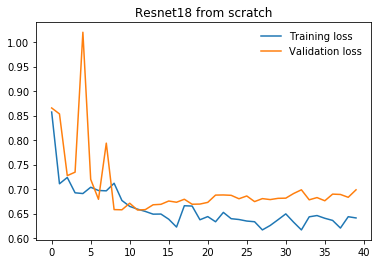

In [81]:
plt.title('Resnet18 from scratch')
plt.plot(train_loss_history, label='Training loss')
plt.plot(val_loss_history, label='Validation loss')
plt.legend(frameon=False)
plt.show()

**3. Report the contingency table, and calculate the overall accuracy, precision,recall, and F1 score of your optimized results.**

In [82]:
lab = []
pred = []
model_ft.eval()
with torch.no_grad():
    for images,labels in dataloaders['val']:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        p = predicted.cpu().numpy()
        label=labels.cpu().numpy()
        pred.append(p)
        lab.append(label)

pred = np.concatenate((pred),axis=0)
lab = np.concatenate((lab),axis=0)

In [83]:
pred

array([1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1])

In [84]:
cm1 = confusion_matrix(lab,pred)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))

accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy Score : ', accuracy1)
# Or print('Accuracy Score: {:.2f}'.format(accuracy_score(lab,pred)))

recall = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Recall Score: ', recall )#tpr, recall=tp/tp+fn
# Or print('Recall Score: {:.2f}'.format(recall_score(lab,pred)))

precision = cm1[0,0]/(cm1[0,0]+cm1[1,0])#tp/tp+fp
print('Precision Score: ', precision)
# Or print('Precision Score: {:.2f}'.format(precision_score(lab,pred)))

recall = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('F1 Score: {:.2f}'.format(f1_score(lab,pred)))

# print('True positive rate : ', recall )#tpr, recall=tp/tp+fn
# fpr=cm1[1,0]/(cm1[1,0]+cm1[1,1])#fp/fp+tn
# print('False positive rate : ', fpr)


Confusion Matrix : 
 [[32 18]
 [15 35]]
Accuracy Score :  0.67
Recall Score:  0.64
Precision Score:  0.6808510638297872
F1 Score: 0.68


## 1.4 Transfer learning:  pre-trained Resnet18 on ImageNet

**1.  Load a Resnet18 model pre-trained on ImageNet dataset.  You can do this by specifying pretrained=True.  Make sure to change the output size to 2**

In [134]:
val_loss_history= []
train_loss_history= []
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [135]:
model_ft = models.resnet18(pretrained=True)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001, betas=(0.9, 0.999),weight_decay=1e-4)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [136]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 0.4689 Acc: 0.7980
val Loss: 0.1231 Acc: 0.9500

Epoch 1/19
----------
train Loss: 0.4142 Acc: 0.8100
val Loss: 0.2024 Acc: 0.9300

Epoch 2/19
----------
train Loss: 0.4016 Acc: 0.8040
val Loss: 0.1439 Acc: 0.9400

Epoch 3/19
----------
train Loss: 0.3190 Acc: 0.8660
val Loss: 0.1885 Acc: 0.9500

Epoch 4/19
----------
train Loss: 0.3501 Acc: 0.8460
val Loss: 0.2168 Acc: 0.9300

Epoch 5/19
----------
train Loss: 0.3767 Acc: 0.8460
val Loss: 0.1404 Acc: 0.9600

Epoch 6/19
----------
train Loss: 0.3273 Acc: 0.8800
val Loss: 0.1494 Acc: 0.9600

Epoch 7/19
----------
train Loss: 0.3039 Acc: 0.8660
val Loss: 0.1567 Acc: 0.9700

Epoch 8/19
----------
train Loss: 0.2950 Acc: 0.8800
val Loss: 0.1010 Acc: 0.9700

Epoch 9/19
----------
train Loss: 0.2661 Acc: 0.8760
val Loss: 0.0891 Acc: 0.9700

Epoch 10/19
----------
train Loss: 0.3130 Acc: 0.8640
val Loss: 0.0969 Acc: 0.9700

Epoch 11/19
----------
train Loss: 0.2435 Acc: 0.9080
val Loss: 0.0921 Acc: 0.9700

Ep

**2.  Train the model for a maximum of 20 epochs.  Record the training lossat each epoch.  Test the model performance on the validation set at eachepoch and record the validation loss.  Tune the hyper-parameters to im-prove the model’s performance.  Plot the overall training and validationloss  curves,  and  report  the  contingency  table,  and  calculate  the  overallaccuracy, precision, recall, and F1 score of your optimized results.**

In [137]:
train_loss_history

[0.46890054309368134,
 0.4141752660870552,
 0.4016066297292709,
 0.31904363971948624,
 0.350138078391552,
 0.37668812966346743,
 0.327322678565979,
 0.30387209171056745,
 0.2949760024547577,
 0.26611160385608673,
 0.31297408163547513,
 0.24350392913818358,
 0.22872681903839112,
 0.25590497606992724,
 0.25006717586517335,
 0.21990305376052857,
 0.21121359360218048,
 0.2825844633579254,
 0.20842634904384613,
 0.1972757709622383]

In [138]:
val_loss_history

[0.12306385695934295,
 0.2023806768655777,
 0.14390623748302458,
 0.18852116495370866,
 0.2168296182155609,
 0.14035376250743867,
 0.14943848103284835,
 0.15673998415470122,
 0.10104230582714081,
 0.0890853625535965,
 0.09693130850791931,
 0.09212492734193801,
 0.10873301327228546,
 0.11564006686210632,
 0.1227114599943161,
 0.08134144186973571,
 0.12628695070743562,
 0.09637010157108307,
 0.10128227949142456,
 0.09385711073875427]

### Reporting training loss every 10 epochs

In [139]:
for x in range(len(train_loss_history)): 
    if x%10 ==0 :
        print(train_loss_history[x])

0.46890054309368134
0.31297408163547513


### Reporting validation loss every 10 epochs

In [140]:
for x in range(len(val_loss_history)): 
    if x%10 ==0 :
        print(val_loss_history[x])

0.12306385695934295
0.09693130850791931


### Plotting the overall training and validation loss curves

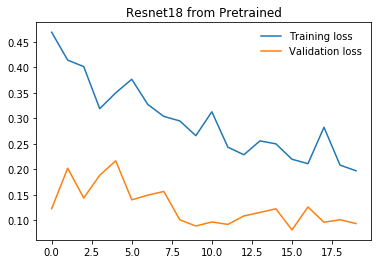

In [141]:
plt.title('Resnet18 from Pretrained')
plt.plot(train_loss_history, label='Training loss')
plt.plot(val_loss_history, label='Validation loss')
plt.legend(frameon=False)
plt.show()

 ### Reporting the contingency table, overall accuracy, precision,recall, and F1 score of the optimized results.

In [142]:
lab = []
pred = []
model_ft.eval()
with torch.no_grad():
    for images,labels in dataloaders['val']:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        p = predicted.cpu().numpy()
        label=labels.cpu().numpy()
        pred.append(p)
        lab.append(label)

pred = np.concatenate((pred),axis=0)
lab = np.concatenate((lab),axis=0)

In [143]:
cm1 = confusion_matrix(lab,pred)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))

accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy Score : ', accuracy1)
# Or print('Accuracy Score: {:.2f}'.format(accuracy_score(lab,pred)))

recall = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Recall Score: ', recall )#tpr, recall=tp/tp+fn
# Or print('Recall Score: {:.2f}'.format(recall_score(lab,pred)))

precision = cm1[0,0]/(cm1[0,0]+cm1[1,0])#tp/tp+fp
print('Precision Score: ', precision)
# Or print('Precision Score: {:.2f}'.format(precision_score(lab,pred)))

recall = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('F1 Score: {:.2f}'.format(f1_score(lab,pred)))

# print('True positive rate : ', recall )#tpr, recall=tp/tp+fn
# fpr=cm1[1,0]/(cm1[1,0]+cm1[1,1])#fp/fp+tn
# print('False positive rate : ', fpr)


Confusion Matrix : 
 [[48  2]
 [ 1 49]]
Accuracy Score :  0.97
Recall Score:  0.96
Precision Score:  0.9795918367346939
F1 Score: 0.97


**3. How is the training on the pre-trained model different from the non pre-trained model?**

We can see from the above graph that when our model wasn't pre-trained, validation loss was greater than the training loss but after pre-training it, the validation loss came out be less than the training loss.

After training on the pre-trained model(transfer learning), it gives higher accuracies than the non pre-trained model. 

With transfer learning, instead of starting the learning process from scratch, we can start from patterns that have been learned when solving a different problem. This way we leverage previous learnings and avoid starting from scratch. 
A pre-trained model is a model that was trained on a large benchmark dataset to solve a problem similar to the one that we want to solve. 

For pretained model, I set pretrain=True, whereas for Non pre-trained, I set pretrain=True. I also changed learning rate from 0.01 to 0.0001 in 1.4 part(where pretrained= True) which increased the accuracy for my model.

 ## 2 Train a Long-Short Term Memory Neural Net-work (LSTM)

**1. Give a short description of your approach, including training/validation/testing split, overall architecture, word embeddings.  This should also include the choice of optimizer and loss functions** 

For the following question I have used LSTM approach. To prepare the data, I have first converted text data into a dataframe. I later on converted all text to lowercase and then removed all punctutaion from text.  

For training/validation/testing step, I have first separated the data into 90% and 10% for training and testing set. I have then later on used (validation_split=0.2) while fitting the model to split the data into 80% and 20% for training and validation set respectively. 

For Loss function and Optimizer, I have used binary cross entropy loss function because I was predicting a binary outocome. I have also used adam optimizer(default setting)


In [118]:
import numpy as np 
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

data=pd.read_csv('yelp_labelled.txt', sep='\t', header=None)
rev=data[0]
lab=data[1]

In [119]:
reviews=rev
label=lab
reviews = reviews.apply(lambda x: x.lower())
reviews = reviews.apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
#print(data[(label==1)].size)
#print(data[label==0].size)

In [120]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)
data = pad_sequences(sequences, maxlen=300)

In [121]:
xtrain, xtest, ytrain, ytest = train_test_split(data, label, test_size = 0.10, random_state = 23)
print(xtrain.shape,ytrain.shape)

In [123]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Conv1D, MaxPooling1D
model = Sequential()
model.add(Embedding(2000, 128, input_length=300))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(xtrain, ytrain, validation_split=0.2, epochs=20)

Train on 720 samples, validate on 180 samples
Epoch 1/20
720/720 [==============================] - 8s 11ms/step - loss: 0.6955 - acc: 0.5000 - val_loss: 0.6904 - val_acc: 0.5833
Epoch 2/20
720/720 [==============================] - 6s 9ms/step - loss: 0.6768 - acc: 0.6778 - val_loss: 0.6604 - val_acc: 0.7111
Epoch 3/20
720/720 [==============================] - 6s 8ms/step - loss: 0.5061 - acc: 0.8347 - val_loss: 0.5431 - val_acc: 0.7389
Epoch 4/20
720/720 [==============================] - 6s 8ms/step - loss: 0.1747 - acc: 0.9500 - val_loss: 0.6963 - val_acc: 0.7333
Epoch 5/20
720/720 [==============================] - 6s 8ms/step - loss: 0.0546 - acc: 0.9875 - val_loss: 0.9749 - val_acc: 0.7278
Epoch 6/20
720/720 [==============================] - 6s 8ms/step - loss: 0.0167 - acc: 0.9958 - val_loss: 1.1793 - val_acc: 0.7556
Epoch 7/20
720/720 [==============================] - 5s 8ms/step - loss: 0.0077 - acc: 0.9986 - val_loss: 1.4104 - val_acc: 0.7278
Epoch 8/20
720/720 [=========

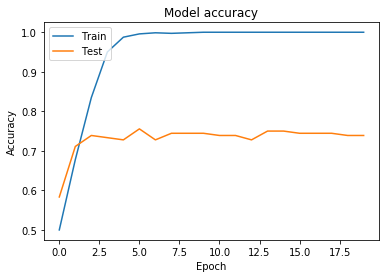

In [124]:
# Plotting training & validation accuracy values

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

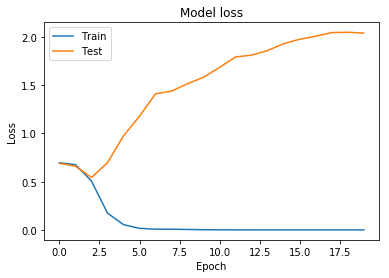

In [125]:
# Plotting training & validation loss values

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [130]:
score,acc = model.evaluate(xtest, ytest, verbose = 2)
print("accuracy: %.2f" % (acc))

accuracy: 0.79


After training the model, I tested my model on the held out test set and gained accuracy of 79%. We can also increase the model accuracy by adding more layers(would have done if we had more time)

I have set model = Sequential() to define the sequence of layers in the model. We can just add more layers to them. 
My model starts with embedding layer which in short lets the network expand each token to a larger vector, allowing the network to represent words in a meaningful way. I passed 2000 as the first argument which is the size of my vocabulary, and 128 as the second, which means that each token can be expanded to a vector of size 128. We give it an input_length of 300, which is the length of each of our sequences.
(Used Tokenizer to vectorize and convert text into sequence so the network can deal with it as input)
Have also added droput layer. Dropouts are used so that our model doesn't overfit.
Added CNN layer to increase the accuracy along with maxpooling layer for size of 4. 

Model loss and Model accuracy plot suggest that we could have even stop after 6 epoch or something. After 6 epochs, its not actually increasing the accuracy. 